In [2]:
import requests
import json
import pickle
from bs4 import BeautifulSoup as bs
import re

In [3]:
def get_seasons():
    seasons = range(1,11)
    season_list = []
    season_url = 'https://adventuretime.fandom.com/api/v1/Articles/List?expand=1&category=season+{}&namespaces=0&limit=50'
    for season in seasons:
        r = requests.get(season_url.format(season)).text
        json_r = json.loads(r)
        season_list.append(json_r)
    return season_list

# creates a dictionary with episode title as key and its season as value
episode_season = {}
for i, season in enumerate(get_seasons()):
    for episode in season['items']:
        title = episode['url'][6:]
        if ('Adventure_Time_Short:' in title or
            'Frog_Seasons:' in title or
            'Islands' == title or
            'Stakes' == title or
            'Elements' == title or
            'MonthBomb' == title): # a few titles that snuck in which are not episodes
            continue
        episode_season[title] = i+1

# creates a dictionary with season number as key and a list of episodes as value
season_episodes = {episode_season[e]:[]  for e in episode_season}
for ep in episode_season:
    season_episodes[episode_season[ep]].append(ep)

# returns a list of lines with charater names
def get_transcript(title):
    season_num = episode_season[title]
    transcript = pickle.load(open(f'seasons/season{season_num}/transcripts/{title}.txt', 'rb'))
    return transcript

# returns a list of lines without character names
def get_transcript_text(title):
    transcript = get_transcript(title)
    text = [re.sub(r'^.*?:\s*', '', line) for line in transcript]
    return text

# returns a dictionary with each character as key and their respective lines
# as values stored as a list
def get_transcript_characters(title):
    transcript = get_transcript(title)
    characters = [re.search(r'^.*?:', line).group()[:-1] for line in transcript]
    character_lines = {}
    for character in characters:
        character_lines[character] = []
    for line in transcript:
        character = re.search(r'^.*?:', line).group()[:-1]
        text = re.sub(r'^.*:\s', '', line)
        character_lines[character].append(text)
    return character_lines

def get_article(title):
    season_num = episode_season[title]
    article = pickle.load(open(f'seasons/season{season_num}/articles/{title}.json', 'rb'))
    return article

def get_major_characters(title):
    major_characters_raw = next(x for x in get_article(title)['sections'] 
                                    if (x['title'].lower().replace(u'\xa0', u' ') == 'major characters'
                                    or x['title'].lower() == 'main characters')) # workaround until wiki updates
    major_characters = major_characters_raw['content'][0]['elements']
    major_characters = [c['text'] for c in major_characters]
    major_characters = [c.replace(u'\xa0', u' ') for c in major_characters]
    major_characters = [re.sub(r'\s*\(.*?\)', '', c) for c in major_characters if c != 'Snail']
    return major_characters

def get_minor_characters(title):
    minor_characters_raw = next(x for x in get_article(title)['sections'] 
                                    if x['title'].lower() == 'minor characters')
    minor_characters = minor_characters_raw['content'][0]['elements']
    minor_characters = [c['text'] for c in minor_characters]
    minor_characters = [c.replace(u'\xa0', u' ') for c in minor_characters]
    minor_characters = [re.sub(r'\s*\(.*?\)', '', c) for c in minor_characters if c != 'Snail']
    return minor_characters

def get_all_characters(title):
    return get_major_characters(title) + get_minor_characters(title)

# Network analysis

In [4]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
fig_size = (16,8)
%matplotlib inline
from itertools import combinations
from fa2 import ForceAtlas2
import community
import matplotlib.style as style
style.use('ggplot')

### Creating the network

In [5]:
# makes a directed graph and an undirected graph from a list
# of season numbers i.e. get_graphs_from([1,2])
def get_graphs_from(seasons):
    DG = nx.DiGraph()
    for season in seasons:
        for episode_title in season_episodes[season]:
            if episode_title == 'Come_Along_With_Me': # excludes come along with me since it is an anomaly
                continue
            DG.add_edges_from(combinations(get_all_characters(episode_title),2))
    G = DG.to_undirected()
    return DG, G

DG, G = get_graphs_from(range(1,11))
degree = list(dict(DG.degree()).values())
print(f"Number of nodes in network: {len(DG.nodes)}")
print(f"Number of edges in network: {len(DG.edges)}")

Number of nodes in network: 956
Number of edges in network: 13075


We start off by looking at network statistics for the characters across the entire series to get a sense of what to look for.

**Exploration of character importance (degree and centrality measurements)**

In [6]:
# creates a dictionary with season number as key and a tuple of directed and
# undirected graph as value for each season
network_season = {i:get_graphs_from([i]) for i in range(1,11)}

def sort_graph_property(graph):
    return sorted(dict(graph).items(), key = lambda x: x[1], reverse = True)

# sorted out degree per season and for entire series
out_degree_season = [sort_graph_property(network[0].out_degree)
                      for network in list(network_season.values())]
out_degree_all = sort_graph_property(DG.out_degree)

# sorted in degree per season and for entire series
in_degree_season = [sort_graph_property(network[0].in_degree)
                      for network in list(network_season.values())]
in_degree_all = sort_graph_property(DG.in_degree)

# sorted degree per season and for entire series
degree_season = [sort_graph_property(network[0].degree)
                      for network in list(network_season.values())]
degree_all = sort_graph_property(DG.degree)


# sorted betweenness centrality per season and for entire series
betweenness_season = [sort_graph_property(nx.algorithms.centrality
                                          .betweenness_centrality(network[0]))
                      for network in list(network_season.values())]
betweenness_all = sort_graph_property(nx.algorithms.centrality
                                      .betweenness_centrality(DG))

# sorted eigenvector centrality per season and for entire series
eigenvector_season = [sort_graph_property(nx.algorithms.centrality
                                        .eigenvector_centrality(network[0]))
                      for network in list(network_season.values())]
eigenvector_all = sort_graph_property(nx.algorithms.centrality
                                      .eigenvector_centrality(DG))

# sorted degree centrality per season and for entire series
degree_centr_season = [sort_graph_property(nx.algorithms.centrality
                                        .degree_centrality(network[0]))
                      for network in list(network_season.values())]
degree_centr_all = sort_graph_property(nx.algorithms.centrality.degree_centrality(DG))

In [7]:
def format_table_data(data):
    return ['{}: {}'.format(r[0], round(r[1],3)) for r in data]

pd.DataFrame({'Out-degree': format_table_data(out_degree_all[:10]),
              'In-degree': format_table_data(in_degree_all[:10]),
              'Total degree': format_table_data(degree_all[:10])})

Out-degree                In-degree  \
0                  Finn: 832                 BMO: 186   
1                  Jake: 820        Candy People: 173   
2                   BMO: 363                Jake: 158   
3    Princess Bubblegum: 339                Finn: 133   
4              Ice King: 320      Lady Rainicorn: 132   
5             Marceline: 237            Ice King: 128   
6  Lumpy Space Princess: 216  Princess Bubblegum: 122   
7        Lady Rainicorn: 158              Gunter: 106   
8                Gunter: 150         Tree Trunks: 105   
9     Peppermint Butler: 142   Peppermint Butler: 101   

                Total degree  
0                  Jake: 978  
1                  Finn: 965  
2                   BMO: 549  
3    Princess Bubblegum: 461  
4              Ice King: 448  
5             Marceline: 336  
6          Candy People: 303  
7  Lumpy Space Princess: 302  
8        Lady Rainicorn: 290  
9                Gunter: 256

To no surprise we see that the central characters of the show have the largest out-degree, meaning they influence the most characters throughout the show.

To gain an understanding of the characters, we looked at their degrees along with a few centrality measures. These being Betweenness, Eigenvector and degree centrality.

 * Betweenness centrality is a measure of how often a node is part of the shortest path between two other nodes.

* Eigenvector centrality is used to get see if important characters are often linked with other important characters, thus making them more important.


* Degree centrality is the simplest form of centrality measure. This is the propability that a node is passed through when traversing the network.


In [8]:
pd.DataFrame({'Betweenness': format_table_data(betweenness_all[:10]),
              'Eigenvector': format_table_data(eigenvector_all[:10]),
              'Degree centrality': format_table_data(degree_centr_all[:10])})

Betweenness                Eigenvector  \
0                 Jake: 0.195        Candy People: 0.197   
1                 Finn: 0.148                 BMO: 0.148   
2                  BMO: 0.093    Peppermint Butler: 0.14   
3   Princess Bubblegum: 0.071      Lady Rainicorn: 0.136   
4             Ice King: 0.069            Ice King: 0.134   
5       Lady Rainicorn: 0.049         Tree Trunks: 0.131   
6         Candy People: 0.045                Jake: 0.127   
7  Lumpy Space Princess: 0.04  Princess Bubblegum: 0.126   
8          Tree Trunks: 0.033             Mr. Pig: 0.124   
9               Gunter: 0.032                Wyatt: 0.12   

             Degree centrality  
0                  Jake: 1.024  
1                   Finn: 1.01  
2                   BMO: 0.575  
3    Princess Bubblegum: 0.483  
4              Ice King: 0.469  
5             Marceline: 0.352  
6          Candy People: 0.317  
7  Lumpy Space Princess: 0.316  
8        Lady Rainicorn: 0.304  
9                Gunter: 0.268

Both betweenness and degree centrality doesn't really tell us anything too interesting since it's the same bunch of central characters to the show which have the highest of those measures, but they were worth exploring. Eigenvector centrality, however, seems to favor characters which are often *associated* with important characters. The Candy People and Peppermint Butler is very often with Princess Bubblegum since she governs the Candy Kingdom where the Candy People recide and Peppermint Butler is following her every step. BMO is very often with Finn and Jake since they all live together in the tree house. Tree Trunks and Mr. Pig are married and somewhat often run into problems which Finn and Jake solves (Wyatt, who's Tree Trunks ex-husband, is also shown to have a high Eigenvector centrality).


In [9]:
pd.DataFrame({'season {}'.format(s+1): format_table_data(l[:5]) for s, l in enumerate(eigenvector_season)})

season 1           season 2                season 3  \
0         Tree Trunks: 0.301   Mr. Goose: 0.405  Two-Headed Duck: 0.384   
1            King Worm: 0.29  Mrs. Yoder: 0.384          Mr. Pig: 0.343   
2       Lady Rainicorn: 0.27         Cat: 0.297      Tree Trunks: 0.307   
3           Centipede: 0.229    Chipmunk: 0.256             Phil: 0.275   
4  Wildberry Princess: 0.206        Owls: 0.221       Punch Bowl: 0.246   

                     season 4                 season 5             season 6  \
0  Scientific Parasite: 0.328      Candy People: 0.217  Candy People: 0.272   
1     Gumball Guardian: 0.304            Gunter: 0.211   King of Ooo: 0.247   
2            Jellyfish: 0.292               BMO: 0.201      Penguins: 0.214   
3                  Cow: 0.226  Gumball Guardian: 0.175   Laser Wizard: 0.21   
4        Banana Guards: 0.207               Finn: 0.16          Bufo: 0.192   

                 season 7               season 8                   season 9  \
0             Worm: 0.246             BMO: 0.263  Lumpy Space People: 0.354   
1  Marceline's mom: 0.238     Candy People: 0.24                Wyatt: 0.33   
2     Spider Ghost: 0.221        The Lich: 0.229              Me-Mow: 0.307   
3          Toronto: 0.212  Slime Princess: 0.206          Cosmic Owl: 0.285   
4         Coal Man: 0.198          Gunter: 0.189              Prismo: 0.266   

           season 10  
0  The Morrow: 0.358  
1    Squirrel: 0.322  
2     Scorcher: 0.29  
3  Sir Slicer: 0.262  
4         Ash: 0.236

This seems to be a pattern throughout the entire series. In season 9 we see Cosmic Owl and Prismo, which are characters very important to the plot of the show.

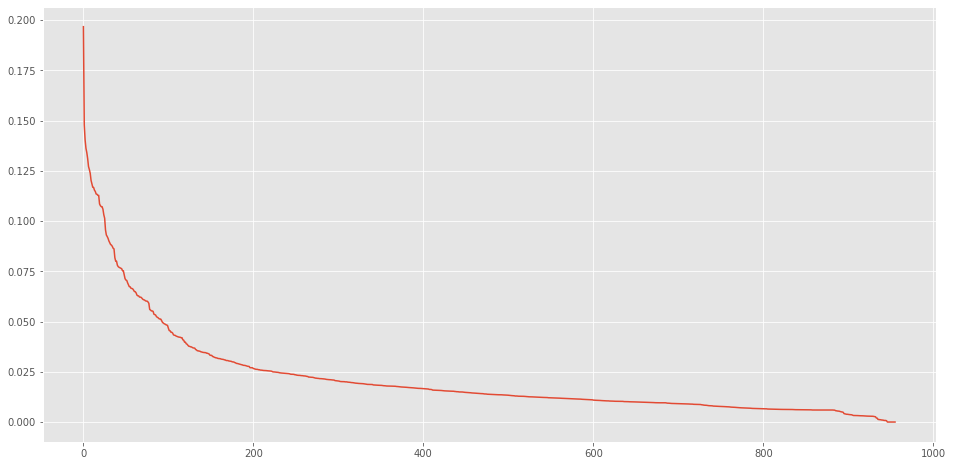

{'Finn': 965, 'Jake': 978}

In [70]:
plt.figure(figsize = fig_size)
plt.plot(list(dict(eigenvector_all).values()))
plt.show()

{c: DG.degree[c] for c in ['Finn', 'Jake']}

With the hypothesis in mind that the show relies less on the main characters throughout the show and tries to build to universe with more robust characters and backstory we plot the average degree per episode for each season to get a feeling for which characters rise and fall in importance.

In [63]:
top_characters = list(dict(degree_all[:10]).keys()) 
char_degree = {c : [] for c in top_characters}

for char in char_degree.keys():
    for i, net in enumerate(network_season.values()):
        if char in dict(net[0].degree).keys():
            char_degree[char].append(net[0].degree[char] / len(season_episodes[i+1]))
        else:
            char_degree[char].append(None)

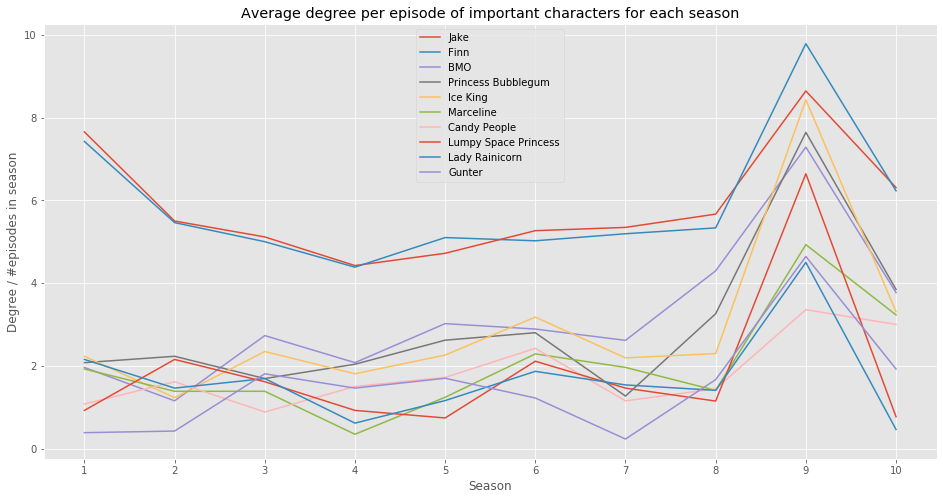

In [66]:
plt.figure(figsize=fig_size)
for char in char_degree:
    plt.plot(char_degree[char], label = char)
plt.xticks(range(10), range(1,11))
plt.legend()
plt.title("Average degree per episode of important characters for each season")
plt.ylabel("Degree / #episodes in season")
plt.xlabel("Season")
plt.savefig('../normalized_degree.png')
plt.show()

We notice that Finn and Jake, the main characters of the show, take a dive at around season 4-5. This is presumably because the show introduces new characters and rely more on those as time goes on. This seems to be the only remarkable change within the main characters.

Since season 9 is heavy on serialisation rather than one-off episodes it causes the out-degree of these main charaters to spike. This is because the main characters are consistently the same throughout the serialised episodes.

**Degree distribution**

We also wish to investigate which kind of network we are dealing with (random, scale-free, etc.). This is done with a degree distribution.

Our preliminary analysis showed that the episode "Come Along With Me", which is the 45 minute series finale, as opposed to the regular 10 minute episodes, skews the data from an average degree of ~27 to ~37 since it has such an immense amount of characters in the episode. Because of this anomaly we decided to drop the episode from the data.

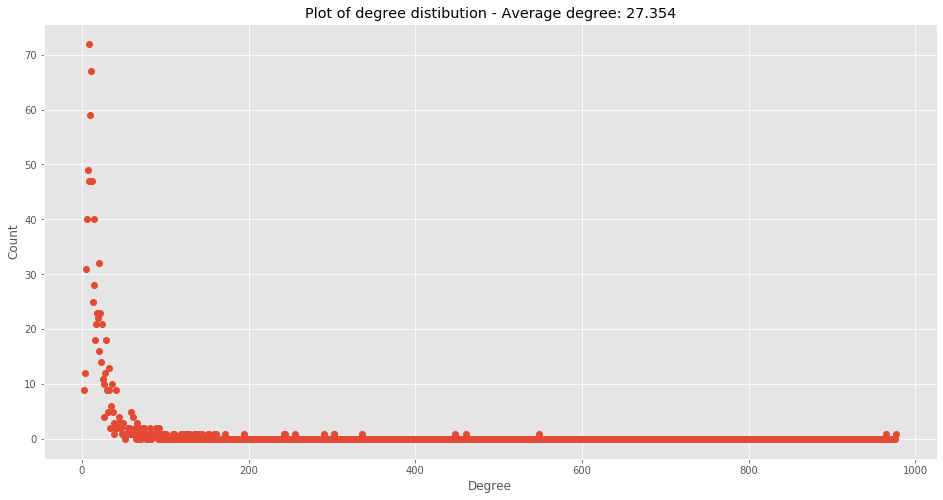

In [67]:
plt.figure(figsize=fig_size)
v = np.arange(min(degree), max(degree)+1)
h_1, b_1 = np.histogram(degree, bins = v)
plt.plot(b_1[:-1], h_1, 'o')
plt.title(f"Plot of degree distibution - Average degree: {round(np.mean(degree),3)}")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

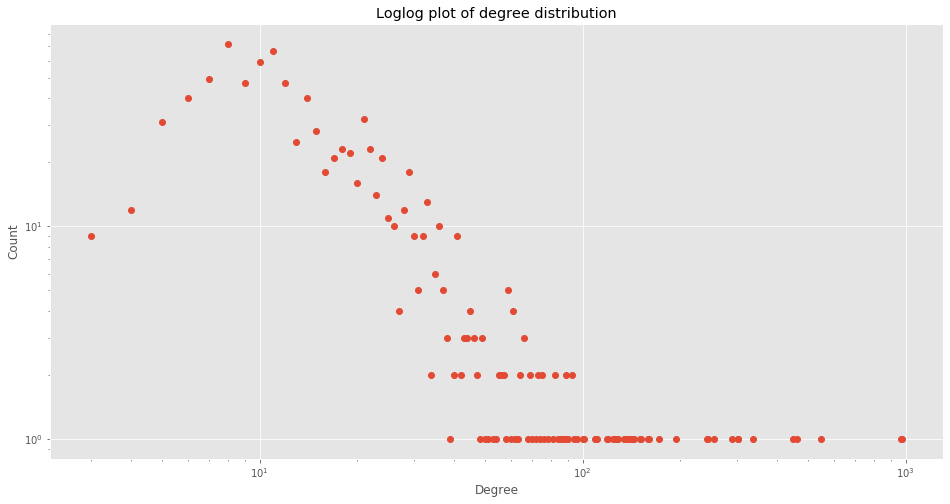

In [68]:
plt.figure(figsize=fig_size)
h_2, b_2 = np.histogram(degree, bins = v)
plt.loglog(b_2[:-1], h_2, 'o')
plt.title('Loglog plot of degree distribution')
plt.ylabel('Count')
plt.xlabel('Degree')
plt.savefig('../loglog.png')
plt.show()

From the loglog plot we clearly see that the degree distribution follows a poissonian distribution indicating a random network.

### Visualizing the network

In [27]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,
                          linLogMode=False,
                          adjustSizes=False,
                          edgeWeightInfluence=1,

                          # Performance
                          jitterTolerance=0.01,
                          barnesHutOptimize=True,
                          barnesHutTheta=0.9,
                          multiThreaded=False,

                          # Tuning
                          scalingRatio=0.01,
                          strongGravityMode=False,
                          gravity=0.1,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:17<00:00, 116.35it/s]

BarnesHut Approximation  took  5.36  seconds
Repulsion forces  took  10.47  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.27  seconds
AdjustSpeedAndApplyForces step  took  0.46  seconds


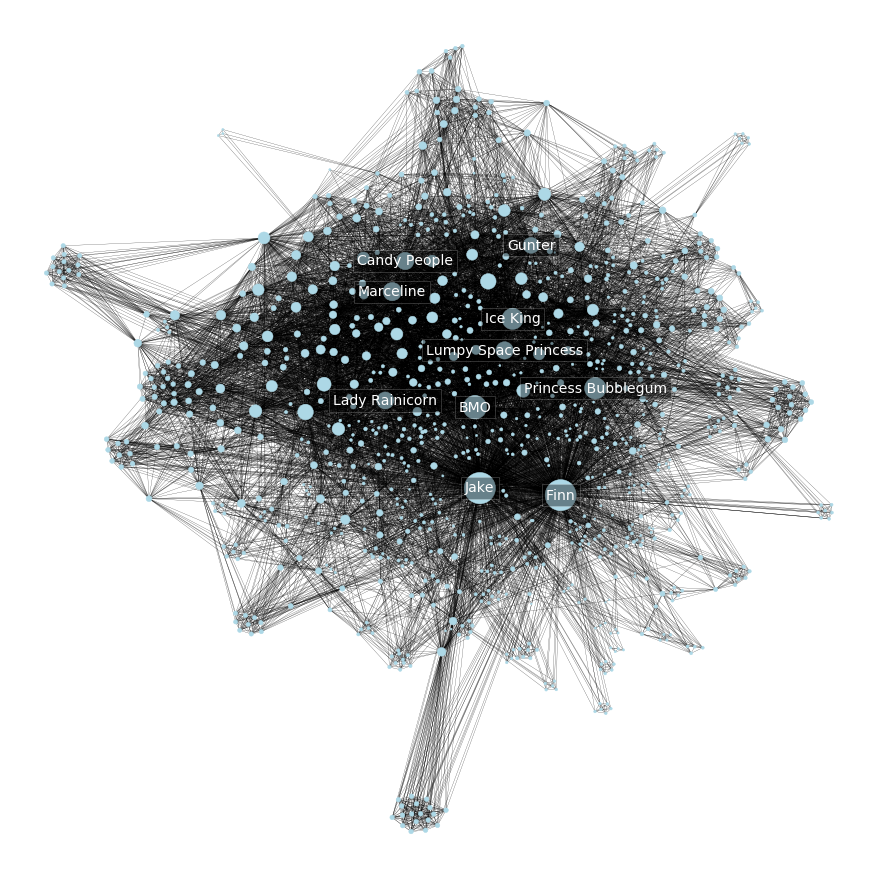

In [48]:
plt.figure(figsize=(12,12))
color_map = get_community_cmap(partition)
labels = {c:c for c in DG.nodes if c in dict(degree_all[:10]).keys()}
node_size = degree
nx.draw(G, node_size = node_size, pos = positions,
        width=.2, node_color = 'lightblue', with_labels = False)
nx.draw_networkx_labels(DG, positions, labels, font_size = 14, font_color = 'w',
                        bbox=dict(facecolor='black', alpha=0.4) )
plt.savefig("../network_plain.png")
plt.show()

There are noticable clusters throughout the network. These are found to represent networks which has characters that are only used in that particular episode which causes them to only connect to each other. An example of this is an episode in which Finn and Jake travels to a city where everyone is a thief. These thief characters are never used again outside of that episode.

In [28]:
# generates random colors to use for the communities
colors = ['#%02x%02x%02x' % tuple(np.random.randint(256, size = 3)) 
            for _ in range(25)]

def get_community_cmap(partition):
    color_map = []
    for com in partition.values():
        color_map.append(colors[com])
    return color_map

In [29]:
partition = community.best_partition(G)
modularity = community.modularity(partition, G)
print(f"Value of modularity found by Louvain Community Detection {modularity}")

communities = {}
for p, c in partition.items():
    communities[c] = communities.get(c, [])
    communities[c].append(p)

Value of modularity found by Louvain Community Detection 0.36696424022572505


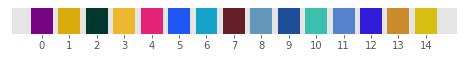

In [30]:
plt.figure(figsize=(8,.5))
plt.bar(range(len(communities.keys())),1 , color = colors)
plt.xticks(range(len(communities.keys())), range(0, len(communities.keys())))
plt.yticks([])
plt.show()

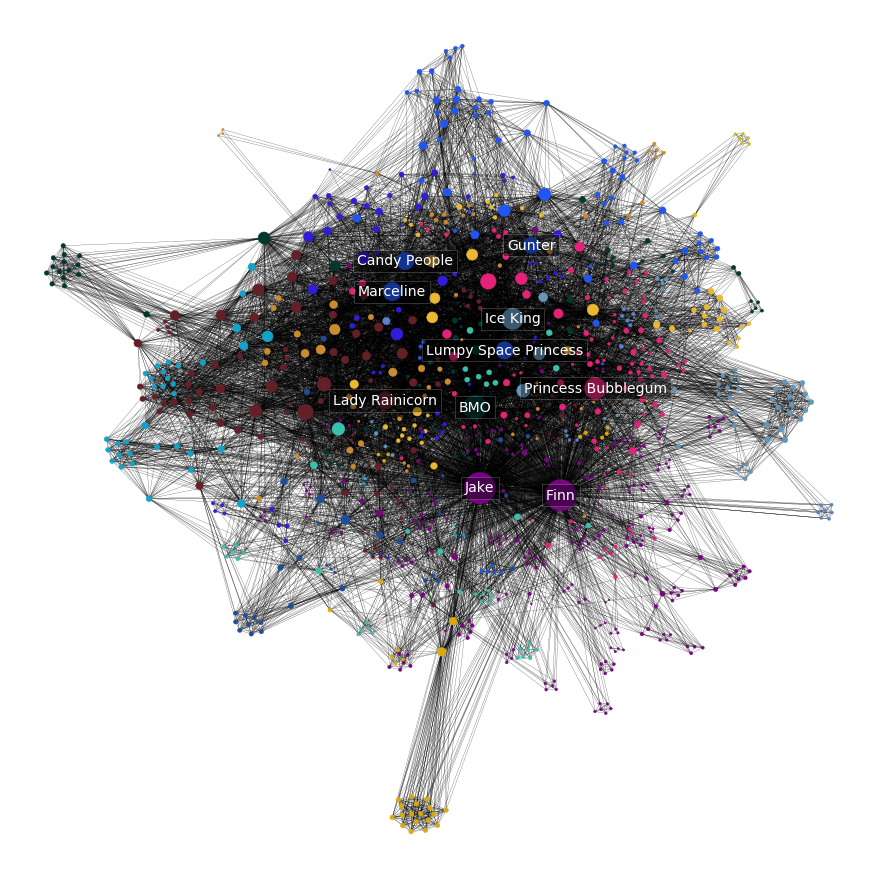

In [31]:
plt.figure(figsize=(12,12))
color_map = get_community_cmap(partition)
labels = {c:c for c in DG.nodes if c in dict(degree_all[:10]).keys()}
#labels = {c:c for c in G.nodes if "princess" in c.lower() and '/' not in c}
#node_size = [x*1E3 for x in nx.algorithms.centrality.eigenvector_centrality(DG).values()]
node_size = degree
nx.draw(G, node_size = node_size, pos = positions,
        width=.2, node_color = color_map, with_labels = False)
nx.draw_networkx_labels(DG, positions, labels, font_size = 14, font_color = 'w',
                        bbox=dict(facecolor='black', alpha=0.4) )
plt.savefig("../network_communities.png")
plt.show()

In [40]:
def modularity_from_nodes(G, nodes):
    subgraph = G.subgraph(nodes)
    partition = community.best_partition(subgraph)
    modularity = community.modularity(partition, subgraph)

    communities = {}
    for p, c in partition.items():
        communities[c] = communities.get(c, [])
        communities[c].append(p)
        
    return modularity, communities

In [39]:
princesses = [p for p in G.nodes if 'princess' in p.lower()]
princess_modularity, princess_partition = modularity_from_nodes(G, princesses)

print(f"Princess modularity {princess_modularity}")

Princess modularity 0.22377556764871454


In [43]:
import plotly.graph_objects as go
import chart_studio.plotly as py
import chart_studio

In [44]:
for node in G.nodes:
    G.nodes[node]['pos'] = positions[node]

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.2, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Rainbow',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=5,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [45]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    char = adjacencies[0]
    node_text.append(f'{char} with the degree {G.degree[char]}')

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [46]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [93]:
import plotly.io as pio
pio.write_html(fig, file='../network.html', auto_open=True)